# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
pip install tensorflow

  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [10]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [11]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [12]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')

    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.output_layer(x, activation=1)

    return x

In [13]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Зробимо порівняння передбачених значеннь з істинними лейблами
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    # Визначимо середню точність використовуючи метод згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [15]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step 100, Loss: 264.2480163574219, Accuracy: 0.72265625
Step 200, Loss: 208.77883911132812, Accuracy: 0.78515625
Step 300, Loss: 181.8103485107422, Accuracy: 0.8125
Step 400, Loss: 141.11190795898438, Accuracy: 0.84765625
Step 500, Loss: 105.13224029541016, Accuracy: 0.90234375
Step 600, Loss: 164.28219604492188, Accuracy: 0.8359375
Step 700, Loss: 120.94610595703125, Accuracy: 0.859375
Step 800, Loss: 88.98358917236328, Accuracy: 0.88671875
Step 900, Loss: 92.6912841796875, Accuracy: 0.88671875
Step 1000, Loss: 98.05308532714844, Accuracy: 0.87890625
Step 1100, Loss: 104.10806274414062, Accuracy: 0.890625
Step 1200, Loss: 82.12954711914062, Accuracy: 0.9140625
Step 1300, Loss: 103.62747192382812, Accuracy: 0.8828125
Step 1400, Loss: 84.74653625488281, Accuracy: 0.87890625
Step 1500, Loss: 81.78499603271484, Accuracy: 0.9296875
Step 1600, Loss: 79.6793212890625, Accuracy: 0.8984375
Step 1700, Loss: 70.79845428466797, Accuracy: 0.8984375
Step 1800, Loss: 92.44522857666016, Accuracy: 0.8

2024-11-21 10:47:48.586643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


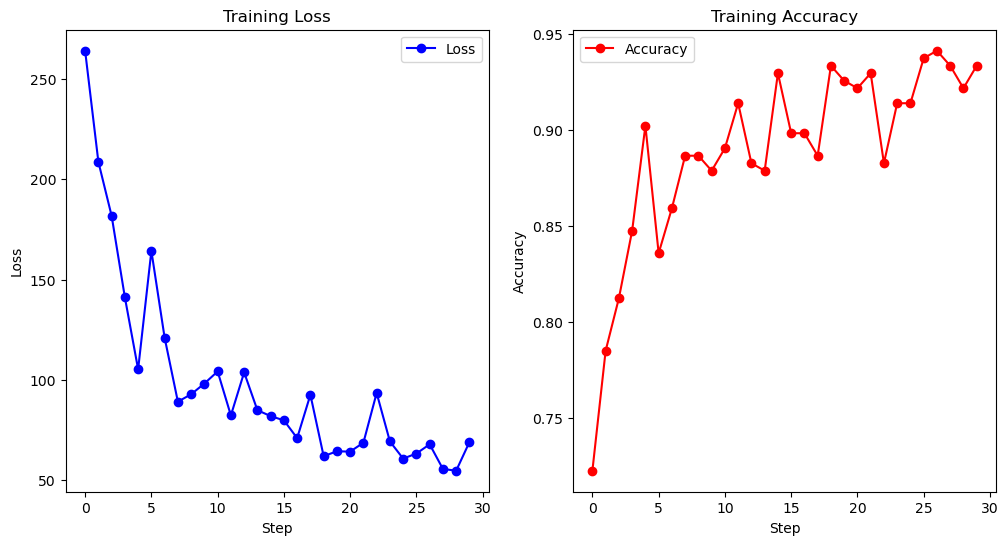

In [16]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', marker='o', linestyle='-', color='red')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# Обчисліть точність навченої нейромережі
from sklearn.metrics import classification_report

# Отримуємо прогнози моделі для тестових зображень
predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виводимо класифікаційний звіт
print(classification_report(y_test, predicted_labels))


predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Обчислюємо матрицю плутанини
cm = confusion_matrix(y_test, predicted_labels)

# Виводимо матрицю плутанини
print("\nМатриця плутанини:")
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.89      0.88      1032
           3       0.83      0.92      0.87      1010
           4       0.91      0.91      0.91       982
           5       0.88      0.86      0.87       892
           6       0.94      0.93      0.94       958
           7       0.92      0.89      0.91      1028
           8       0.88      0.82      0.85       974
           9       0.87      0.88      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Матриця плутанини:
[[ 929    0   12    8    0   12    8    1    7    3]
 [   0 1106    5    6    1    3    4    3    6    1]
 [  12    6  917   38    6    4   12   12   20    5]
 [   4    1   19  930    2   19    1   10   15    9]
 [   4   

In [18]:
# Обчислюємо та виводимо загальну точність на тестових даних

correct_predictions = (predicted_labels == y_test)
test_accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на тестових даних складає: {test_accuracy * 100:.2f}%")

Точність на тестових даних складає: 90.31%


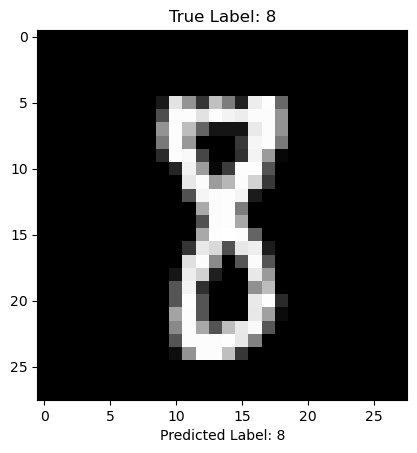

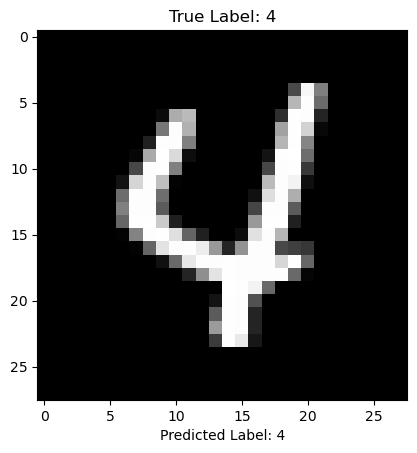

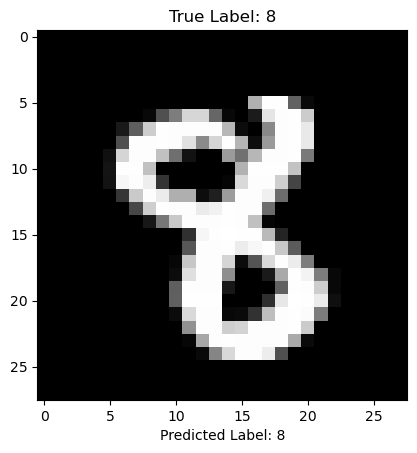

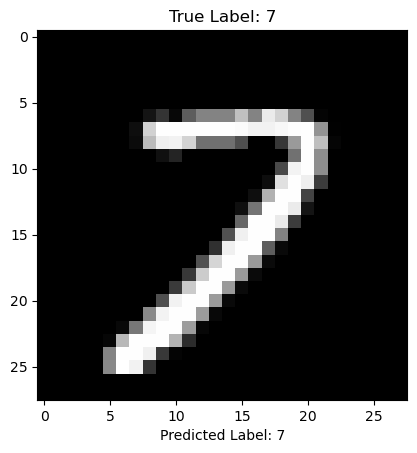

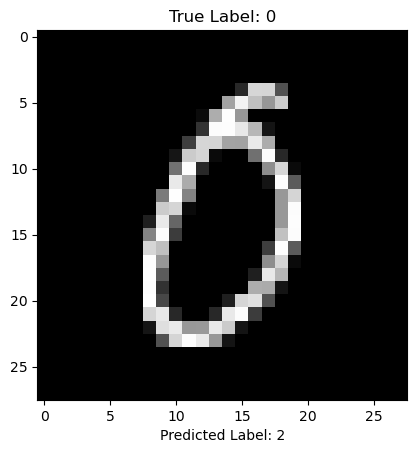

In [19]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Вибираємо 5 випадкових зображень
random_indices = random.sample(range(len(x_test)), 5)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Виведення зображень та передача їх у нейронну мережу
for i in range(5):
    image = sample_images[i].reshape((28, 28))
    label = sample_labels[i]

    # Відображення зображення
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {label}")

    # Передача зображення у нейронну мережу
    prediction = neural_net(sample_images[i:i+1])
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    plt.xlabel(f"Predicted Label: {predicted_label}")
    plt.show()

**Висновки:**

- Точність нейромережі на тестових даних складає 90.38%, що є високим показником для короткого часу навчання. Однак, така точність все ще не є ідеальною для використання в реальних завданнях. Тому слід бути обережним з результатами, які видає модель.

- Порівняння прогнозів з правильними значеннями показує, що модель навчена досить добре, хоча і не досконало. Вона здатна розпізнавати цифри, але допускає помилки, особливо на складних прикладах.

- Модель помиляється приблизно 1 раз з 5-ти. Помилки виникають на складних прикладах, та і на таких значеннях, що є неочевидними навіть для людини. Все через значну схожість з іншими значеннями, які мають щільне скупчення пікселів в області, що ускладнює їх розпізнавання

- Покращення моделі може бути досягнуто шляхом збільшення кількості навчальних епох, використанням більш складних архітектур або застосуванням методів регуляризації для запобігання перенавчанню.

Загалом, модель показує багатообіцяючі результати для початкового етапу, але потребує подальшого вдосконалення для досягнення більшої точності та надійності в задачах розпізнавання цифр.